In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction, TimeSeriesTransformerModel 
from transformers.models.time_series_transformer.modeling_time_series_transformer import TimeSeriesTransformerEncoder
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy import stats
import json 
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime
from torch.utils.data import Dataset, DataLoader

from pathlib import Path
from core.multimodal.dataset import collate_fn, ASASSNVarStarDataset
from functools import partial
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits

from core.spectra.dataset import SpectraVDataset
from core.spectra.model import GalSpecNet

In [55]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True

In [56]:
data_root = '/home/mariia/AstroML/data/asassn'
lamost_spec_file='Spectra/lamost_spec.csv'
lamost_spec_dir='Spectra/v2'
# v_file = 'asassn_catalog_full.csv'
v_file = 'v.csv'
spectra_v_file = 'spectra_v_merged.csv'

In [5]:
CLASSES = ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW',
           'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR']

In [7]:
def train_epoch():
    model.train()
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    for fluxes, label in tqdm(train_dataloader):
        fluxes, label = fluxes.to(device), label.to(device)

        optimizer.zero_grad()

        logits = model(fluxes)
        loss = criterion(logits, label)
        total_loss.append(loss.item())

        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == label).sum().item()

        total_correct_predictions += correct_predictions
        total_predictions += label.size(0)

        loss.backward()
        optimizer.step()

    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions
    
def val_epoch():
    model.eval()
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for fluxes, label in tqdm(val_dataloader):
            fluxes, label = fluxes.to(device), label.to(device)

            logits = model(fluxes)
            loss = criterion(logits, label)
            total_loss.append(loss.item())

            probabilities = torch.nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            correct_predictions = (predicted_labels == label).sum().item()
    
            total_correct_predictions += correct_predictions
            total_predictions += label.size(0)

    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions

In [20]:
class SpectraVDataset(Dataset):
    def __init__(self, data_root, lamost_spec_dir, spectra_v_file, split='train', classes=None, z_corr=False):
        self.data_root = data_root
        self.lamost_spec_dir = os.path.join(data_root, lamost_spec_dir)
        self.spectra_v_file = os.path.join(data_root, spectra_v_file)
        self.split = split
        self.z_corr = z_corr

        self.df = pd.read_csv(self.spectra_v_file)
        self.df = self.df[['edr3_source_id', 'variable_type', 'spec_filename']]

        if classes:
            self.df = self.df[self.df['variable_type'].isin(classes)]

        self._split()

        self.id2target = {i: x for i, x in enumerate(sorted(self.df['variable_type'].unique()))}
        self.target2id = {v: k for k, v in self.id2target.items()}
        self.num_classes = len(self.id2target)

    def _split(self):
        total_size = len(self.df)
        train_size = int(total_size * 0.7)
        val_size = int(total_size * 0.15)

        shuffled_df = self.df.sample(frac=1, random_state=42)

        if self.split == 'train':
            self.df = shuffled_df[:train_size]
        elif self.split == 'val':
            self.df = shuffled_df[train_size:train_size + val_size]
        elif self.split == 'test':
            self.df = shuffled_df[train_size + val_size:]
        else:
            self.df = shuffled_df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        el = self.df.iloc[idx]
        variable_type, spec_filename = el['variable_type'], el['spec_filename']
        label = self.target2id[variable_type]

        # read spectra
        spectra = self.readLRSFits(os.path.join(self.lamost_spec_dir, spec_filename))
        original_wavelengths, fluxes = spectra[:, 0], spectra[:, 1]

        # interpolate
        wavelengths = np.arange(3850, 9000, 2)
        fluxes = np.interp(wavelengths, original_wavelengths, fluxes)

        # normalize
        # fluxes = (fluxes - fluxes.mean()) / fluxes.std()
        N = np.sum(fluxes ** 2)
        fluxes = fluxes / np.sqrt(N)

        # reshape so batches are [N, 1, (9000-3850)//2]
        fluxes = fluxes.reshape(1, -1).astype(np.float32)

        return fluxes, label

    def readLRSFits(self, filename):
        """
        Read LAMOST fits file
          adapted from https://github.com/fandongwei/pylamost

        Parameters:
        -----------
        filename: str
          name of the fits file
        z_corr: bool.
          if True, correct for measured radial velocity of star

        Returns:
        --------
        spec: numpy array
          wavelength, flux, inverse variance
        """

        hdulist = fits.open(filename)
        len_list = len(hdulist)

        if len_list == 1:
            head = hdulist[0].header
            scidata = hdulist[0].data
            coeff0 = head['COEFF0']
            coeff1 = head['COEFF1']
            pixel_num = head['NAXIS1']
            specflux = scidata[0,]
            ivar = scidata[1,]
            wavelength = np.linspace(0, pixel_num - 1, pixel_num)
            wavelength = np.power(10, (coeff0 + wavelength * coeff1))
            hdulist.close()
        elif len_list == 2:
            head = hdulist[0].header
            scidata = hdulist[1].data
            wavelength = scidata[0][2]
            ivar = scidata[0][1]
            specflux = scidata[0][0]
        else:
            raise ValueError(f'Wrong number of fits files. {len_list} should be 1 or 2')

        if self.z_corr:
            try:
                # correct for radial velocity of star
                redshift = head['Z']
            except Exception as e:
                print(e, 'Setting redshift to zero')
                redshift = 0.0

            wavelength = wavelength - redshift * wavelength

        return np.vstack((wavelength, specflux, ivar)).T

In [43]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=3, short_cut=True):
        super(ResNetBlock, self).__init__()
        
        self.short_cut = short_cut
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=stride)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.pool = nn.MaxPool1d(kernel_size=kernel_size, stride=1, padding=2)
        
        if self.short_cut:
            self.shortcut_conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.pool(out)
        
        if self.short_cut:
            identity = self.shortcut_conv(identity)
        
        out += identity
        
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super(ResNet, self).__init__()

        self.model = nn.Sequential(
            ResNetBlock(1, 16),
            ResNetBlock(16, 32),
            ResNetBlock(32, 64),
            # ResNetBlock(64, 128),
            # ResNetBlock(128, 256),
            # ResNetBlock(256, 512)
        )
        self.dropout = nn.Dropout(dropout)
        self.mlp = nn.Sequential(
            nn.Linear(6016, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.mlp(x)

        return x

In [50]:

train_dataset = SpectraVDataset(data_root, lamost_spec_dir, spectra_v_file, classes=None, split='train')
val_dataset = SpectraVDataset(data_root, lamost_spec_dir, spectra_v_file, classes=None, split='val')

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [52]:
train_dataset.df['variable_type'].value_counts()

variable_type
EW       4513
SR       3407
EA       2087
RRAB     1798
L        1504
EB       1431
ROT      1324
RRC       623
VAR       414
ROT:      264
M         229
HADS      198
DSCT      183
LSP        31
DCEP       30
YSO        28
SRD        15
CWB        13
DCEPS      13
RRD        13
DSCT:      10
CWA        10
UV          6
ELL         4
SXPHE       3
M:          3
ZAND        2
RVA         1
HB          1
UG          1
GCAS:       1
Name: count, dtype: int64

In [45]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Using', device)

model = ResNet(train_dataset.num_classes)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

Using cuda:1


In [46]:
for i in range(20):
    print(f'Epoch {i}')
    
    train_loss, train_acc = train_epoch()
    print(f'Train Loss: {round(train_loss, 3)} Acc: {round(train_acc, 2)}')
    
    val_loss, val_acc = val_epoch()
    print(f'Val Loss: {round(val_loss, 3)} Acc: {round(val_acc, 2)}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 124/124 [01:52<00:00,  1.10it/s]


Train Loss: 1.122 Acc: 0.61


100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:26<00:00,  1.03it/s]


Val Loss: 3.35 Acc: 0.39
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 124/124 [01:53<00:00,  1.09it/s]


Train Loss: 0.819 Acc: 0.7


100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:25<00:00,  1.07it/s]


Val Loss: 4.825 Acc: 0.3
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 124/124 [01:50<00:00,  1.12it/s]


Train Loss: 0.735 Acc: 0.73


100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:24<00:00,  1.11it/s]


Val Loss: 3.767 Acc: 0.44
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 124/124 [01:54<00:00,  1.08it/s]


Train Loss: 0.679 Acc: 0.75


100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:25<00:00,  1.07it/s]


Val Loss: 3.637 Acc: 0.42
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 124/124 [01:53<00:00,  1.09it/s]


Train Loss: 0.628 Acc: 0.77


100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:23<00:00,  1.15it/s]


Val Loss: 3.193 Acc: 0.41
Epoch 5


  9%|███████                                                                         | 11/124 [00:10<01:44,  1.08it/s]


KeyboardInterrupt: 

In [52]:
dataset = SpectraVDataset(data_root, lamost_spec_dir, spectra_v_file, classes=CLASSES, split='all')
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [54]:
for i in tqdm(range(len(dataset))):
    X, y = dataset[i]
    
    if X.std() < 0.01:
        print(i)

100%|██████████████████████████████████████████████████████████████████████████| 22673/22673 [02:37<00:00, 143.81it/s]


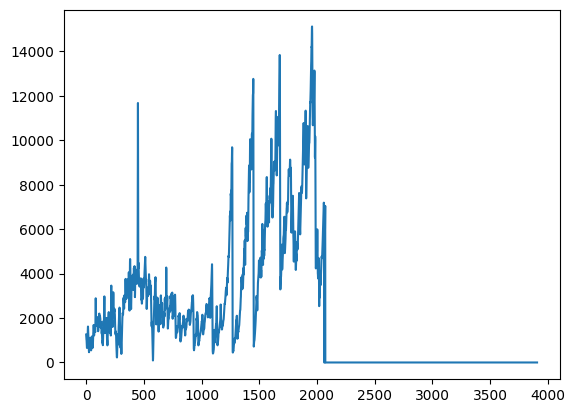

In [53]:
plt.plot(dataset[7984][0])

In [50]:
stats.median_abs_deviation(dataset[7984][0])

0.0

In [48]:
dataset[873][0].std()

102.31893169892906

In [14]:
model = GalSpecNet(dataset.num_classes)
criterion = nn.CrossEntropyLoss()

In [15]:
X, y = next(iter(dataloader))

In [27]:
for X, y in tqdm(dataloader):
    try:
        out = model(X)
        loss = criterion(out, y)
    except:
        break

100%|█████████████████████████████████████████████████████████████████████████████| 1418/1418 [03:09<00:00,  7.48it/s]


In [8]:
for i in tqdm(range(len(dataset))):
    try:
        dataset[i]
    except:
        print(i)

100%|██████████████████████████████████████████████████████████████████████████| 22673/22673 [03:03<00:00, 123.26it/s]


In [12]:
dataset[3]

(array([[ 1.710324 ,  1.5638419,  1.1897354, ..., -1.8659915, -1.7525114,
         -1.6299031]], dtype=float32),
 7)

1

In [57]:
spec_df = pd.read_csv(os.path.join(data_root, lamost_spec_file), index_col=0)
v_df = pd.read_csv(os.path.join(data_root, v_file))

v_df = v_df.drop_duplicates(subset=['edr3_source_id'])
spec_df = spec_df.drop_duplicates(subset=['edr3_source_id'])

df = pd.merge(v_df, spec_df, on='edr3_source_id', how='inner')

KeyError: Index(['edr3_source_id'], dtype='object')

In [328]:
source_ids = []

for i in range(len(df)):
    el = df.iloc[i]
    path = el['spec_filename']
    
    if not os.path.exists(os.path.join(data_root, lamost_spec_dir, path)):
        source_ids.append(el['edr3_source_id'])
        print(i, el['edr3_source_id'])

1061 EDR3 2181169802362836992
1271 EDR3 3201810952808626304
2465 EDR3 2110264427784391168
3046 EDR3 1314026659889734400
3438 EDR3 346213160500048000
7389 EDR3 1343808100557352576
8500 EDR3 2075399704356522112
10343 EDR3 673844638911800704
11130 EDR3 1001510064745073536
11236 EDR3 760365651281045504
11948 EDR3 175763569426444800
14817 EDR3 65864427293364864
15762 EDR3 2797951570192087936
16040 EDR3 267407893664467328
19026 EDR3 961490624634178048


In [329]:
df = df[~df['edr3_source_id'].isin(source_ids)]

In [333]:
weird_sources = ['EDR3 3714273187707121920', 'EDR3 3222213829875076096', 'EDR3 601653935246445696']
df = df[~df['edr3_source_id'].isin(weird_sources)]

In [334]:
df.to_csv(os.path.join(data_root, spectra_v_file), index=False)

EDR3 3714273187707121920


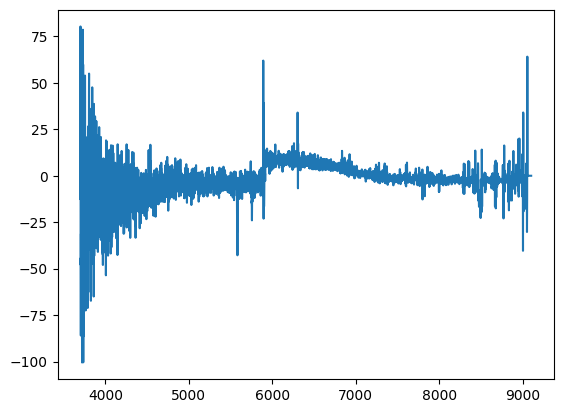

In [330]:
spectra = train_dataset2[3609]
print(train_dataset2.df.iloc[3609]['edr3_source_id'])
plt.plot(spectra[:, 0], spectra[:, 1])

EDR3 3222213829875076096


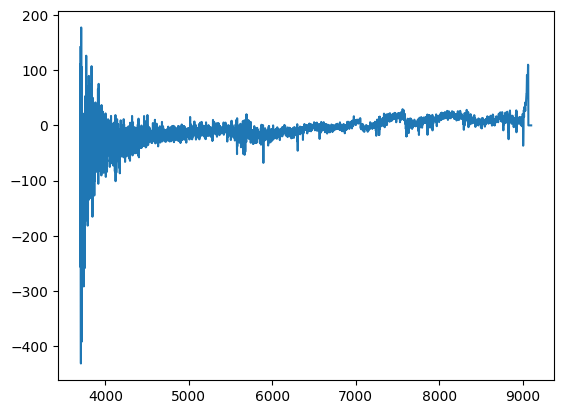

In [331]:
spectra = train_dataset2[3772]
print(train_dataset2.df.iloc[3772]['edr3_source_id'])
plt.plot(spectra[:, 0], spectra[:, 1])

EDR3 601653935246445696


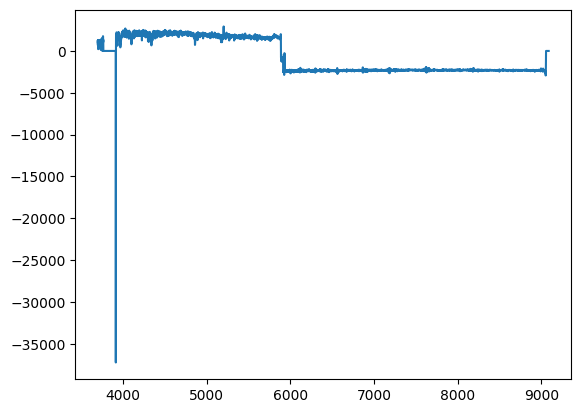

In [332]:
spectra = train_dataset2[8568]
print(train_dataset2.df.iloc[8568]['edr3_source_id'])
plt.plot(spectra[:, 0], spectra[:, 1])

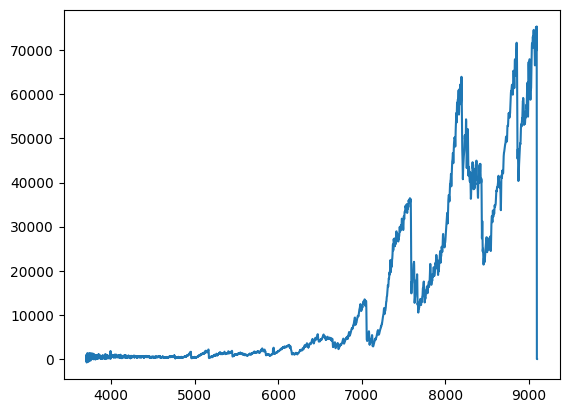

In [326]:
spectra = train_dataset2[8569]
plt.plot(spectra[:, 0], spectra[:, 1])

In [19]:
class SpectraVDataset(Dataset):
    def __init__(self, data_root, lamost_spec_dir, spectra_v_file, split='train', classes=None, z_corr=False):
        self.data_root = data_root
        self.lamost_spec_dir = os.path.join(data_root, lamost_spec_dir)
        self.spectra_v_file = os.path.join(data_root, spectra_v_file)
        self.split = split
        self.z_corr = z_corr

        self.df = pd.read_csv(self.spectra_v_file)
        self.df = self.df[['edr3_source_id', 'variable_type', 'spec_filename']]

        if classes:
            self.df = self.df[self.df['variable_type'].isin(classes)]
            
        self._split()

        self.id2target = {i: x for i, x in enumerate(sorted(self.df['variable_type'].unique()))}
        self.target2id = {v: k for k, v in self.id2target.items()}
        self.num_classes = len(self.id2target)

    def _split(self):
        total_size = len(self.df)
        train_size = int(total_size * 0.7)
        val_size = int(total_size * 0.15)

        shuffled_df = self.df.sample(frac=1, random_state=42)

        if self.split == 'train':
            self.df = shuffled_df[:train_size]
        elif self.split == 'val':
            self.df = shuffled_df[train_size:train_size + val_size]
        elif self.split == 'test':
            self.df = shuffled_df[train_size + val_size:]
        else:
            self.df = shuffled_df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        el = self.df.iloc[idx]
        variable_type, spec_filename = el['variable_type'], el['spec_filename']
        label = self.target2id[variable_type]

        # read spectra
        spectra = self.readLRSFits(os.path.join(self.lamost_spec_dir, spec_filename))
        original_wavelengths, fluxes = spectra[:, 0], spectra[:, 1]
        
        # interpolate
        wavelengths = np.arange(3850, 9000, 2)
        fluxes = np.interp(wavelengths, original_wavelengths, fluxes)

        # normalize
        # fluxes = fluxes / fluxes.mean()
        # fluxes = (fluxes - fluxes.min()) / (fluxes.max() - fluxes.min())
        mean = fluxes.mean()
        mad = stats.median_abs_deviation(fluxes)
        fluxes = (fluxes - mean) / mad

        # reshape so batches are [N, 1, (9000-3850)//2]
        fluxes = fluxes.reshape(1, -1).astype(np.float32)

        return fluxes, label

        
    def readLRSFits(self, filename):
        """
        Read LAMOST fits file
          adapted from https://github.com/fandongwei/pylamost
    
        Parameters:
        -----------
        filename: str
          name of the fits file
        z_corr: bool.
          if True, correct for measured radial velocity of star
    
        Returns:
        --------
        spec: numpy array
          wavelength, flux, inverse variance
        """
    
        hdulist = fits.open(filename)
        len_list = len(hdulist)
        
        if len_list == 1:
            head = hdulist[0].header
            scidata = hdulist[0].data
            coeff0 = head['COEFF0']
            coeff1 = head['COEFF1']
            pixel_num = head['NAXIS1']
            specflux = scidata[0,]
            ivar = scidata[1,]
            wavelength = np.linspace(0, pixel_num - 1, pixel_num)
            wavelength = np.power(10, (coeff0 + wavelength * coeff1))
            hdulist.close()
            
        elif len_list == 2:
            head = hdulist[0].header
            scidata = hdulist[1].data
            wavelength = scidata[0][2]
            ivar = scidata[0][1]
            specflux = scidata[0][0]
    
        if self.z_corr:
            try:
                # correct for radial velocity of star
                redshift = head['Z']
            except Exception:
                redshift = 0.0
                
            wavelength = wavelength - redshift * wavelength
    
        return np.vstack((wavelength, specflux, ivar)).T

In [20]:
train_dataset = SpectraVDataset(data_root, lamost_spec_dir, spectra_v_file, classes=CLASSES, split='train')
val_dataset = SpectraVDataset(data_root, lamost_spec_dir, spectra_v_file, classes=CLASSES, split='val')

In [21]:
len(train_dataset), len(val_dataset)

(15871, 3400)

In [37]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

In [38]:
flux, label = next(iter(train_dataloader))

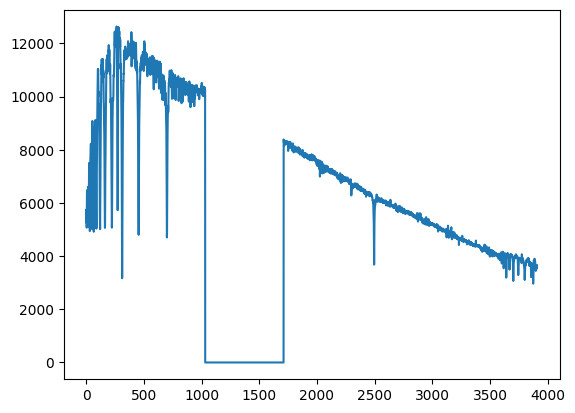

In [47]:
plt.plot(train_dataset.readLRSFits(os.path.join(data_root, lamost_spec_dir, train_dataset.df.iloc[1]['spec_filename']))[:, 1])

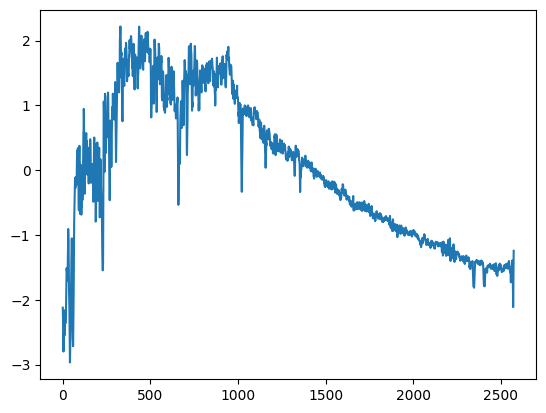

In [39]:
plt.plot(flux[0, 0, :])

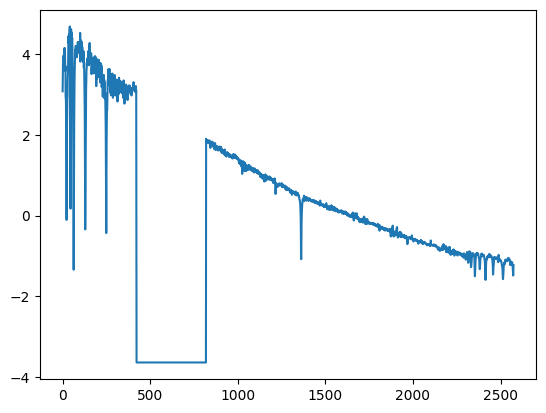

In [43]:
plt.plot(flux[1, 0, :])

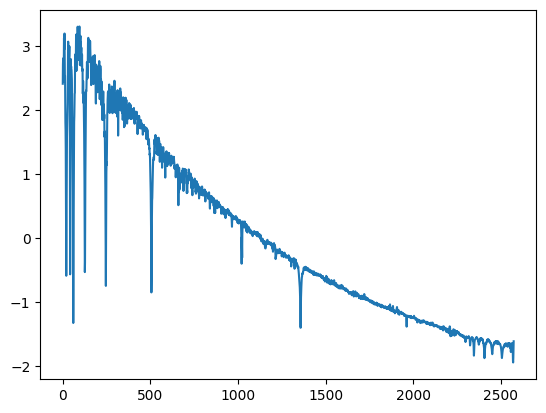

In [44]:
plt.plot(flux[2, 0, :])

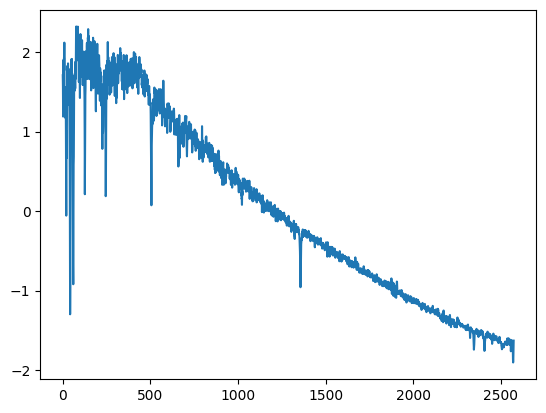

In [45]:
plt.plot(flux[3, 0, :])

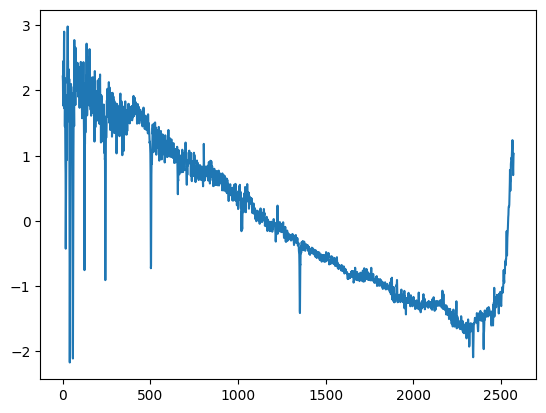

In [46]:
plt.plot(flux[4, 0, :])

In [230]:
conv1 = nn.Sequential(nn.Conv1d(1, 64, kernel_size=3), nn.ReLU())
mp1 = nn.MaxPool1d(kernel_size=4)

x1 = conv1(X)
print(x1.shape)

x2 = mp1(x1)
print(x2.shape)

torch.Size([128, 64, 2573])
torch.Size([128, 64, 643])


In [231]:
conv2 = nn.Sequential(nn.Conv1d(64, 64, kernel_size=3), nn.ReLU())
mp2 = nn.MaxPool1d(kernel_size=4)

x3 = conv2(x2)
print(x3.shape)

x4 = mp2(x3)
print(x4.shape)

torch.Size([128, 64, 641])
torch.Size([128, 64, 160])


In [234]:
conv3 = nn.Sequential(nn.Conv1d(64, 32, kernel_size=3), nn.ReLU())
mp3 = nn.MaxPool1d(kernel_size=4)

x5 = conv3(x4)
print(x5.shape)

x6 = mp3(x5)
print(x6.shape)

torch.Size([128, 32, 158])
torch.Size([128, 32, 39])


In [239]:
conv4 = nn.Sequential(nn.Conv1d(32, 32, kernel_size=3), nn.ReLU())
x7 = conv4(x6)
x7.shape

torch.Size([128, 32, 37])

In [240]:
x8 = x7.view(x7.shape[0], -1)
x8.shape

torch.Size([128, 1184])

In [244]:
mlp = nn.Sequential(
    nn.Linear(32 * 37, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, train_dataset.num_classes)
)

In [245]:
x9 = mlp(x8)
x9.shape

torch.Size([128, 16])

In [251]:
class GalSpecNet(nn.Module):
    
    def __init__(self, num_classes):
        super(GalSpecNet, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv1d(1, 64, kernel_size=3), nn.ReLU())
        self.mp1 = nn.MaxPool1d(kernel_size=4)
        self.conv2 = nn.Sequential(nn.Conv1d(64, 64, kernel_size=3), nn.ReLU())
        self.mp2 = nn.MaxPool1d(kernel_size=4)
        self.conv3 = nn.Sequential(nn.Conv1d(64, 32, kernel_size=3), nn.ReLU())
        self.mp3 = nn.MaxPool1d(kernel_size=4)
        self.conv4 = nn.Sequential(nn.Conv1d(32, 32, kernel_size=3), nn.ReLU())

        self.dropout = nn.Dropout(0.2)
        self.mlp = nn.Sequential(
            nn.Linear(32 * 37, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
            

    def forward(self, x):
        x = self.conv1(x)
        x = self.mp1(x)
        x = self.conv2(x)
        x = self.mp2(x)
        x = self.conv3(x)
        x = self.mp3(x)
        x = self.conv4(x)
        
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.mlp(x)

        return x

In [56]:
model = ResNet(train_dataset.num_classes)

NameError: name 'train_dataset' is not defined

Using cuda:1


Epoch 0


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        # here, which we shouldn't, (e.g., pytorch/pytorch#39570),# here, whi

Train Loss: 2.39 Acc: 0.46


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 6.765 Acc: 0.32
Epoch 1


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.816 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 8.111 Acc: 0.31
Epoch 2


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.733 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 7.158 Acc: 0.32
Epoch 3


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.683 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 8.847 Acc: 0.32
Epoch 4


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.665 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>

AssertionErrorTraceback (most recent call last):
: can only test a child process  File "/global/home/users/mariia/miniconda3/envs/astro/lib/p

Val Loss: 8.353 Acc: 0.32
Epoch 5


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        # here, which we shouldn't, (e.g., pytorch/pytorch#39570),# here, whi

Train Loss: 1.64 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 6.438 Acc: 0.3
Epoch 6


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>

Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
      File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
# here, which we shouldn't, (e.g., pytorch/pytorch#39570),
      File "/g

Train Loss: 1.636 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
    Traceback (most recent call last):
# here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/global/home/users/mariia/mini

Val Loss: 8.156 Acc: 0.32
Epoch 7


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.625 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820># here, which we shouldn't, (e.g., pytorch/pytorch#39570),

  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    assert self._parent_pid == os.getpid()

Val Loss: 8.904 Acc: 0.32
Epoch 8


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in:   File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.609 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 7.831 Acc: 0.32
Epoch 9


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        # here, which we shouldn't, (e.g., pytorch/pytorch#39570),# here, whi

Train Loss: 1.606 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>

AssertionErrorTraceback (most recent call last):
:   File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch

Val Loss: 7.408 Acc: 0.32
Epoch 10


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    Exception ignored in: # here, which we shouldn't, (e.g., pytorch/pytorch#39570),<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>

  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
assert self._parent_pid == os.getpid()

Train Loss: 1.602 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 11.879 Acc: 0.32
Epoch 11


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.615 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 8.339 Acc: 0.31
Epoch 12


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.59 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 10.175 Acc: 0.3
Epoch 13


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.595 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 10.882 Acc: 0.31
Epoch 14


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>

Trace

Train Loss: 1.595 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 8.919 Acc: 0.32
Epoch 15


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:   File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>    
# here, which we shouldn't, (e.g., pytorch/pytorch#39570),Traceback (most recent call last):

  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/global/home/users/mariia/minicond

Train Loss: 1.603 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 6.555 Acc: 0.32
Epoch 16


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.593 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:   File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),Traceback (most recent call last):

  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/global/home/users/mariia/minicond

Val Loss: 7.307 Acc: 0.31
Epoch 17


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>can only test a child process

Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.586 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 8.216 Acc: 0.31
Epoch 18


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
Exception ignored in:   File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>    
assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/data

Train Loss: 1.577 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:   File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>    
# here, which we shouldn't, (e.g., pytorch/pytorch#39570),Traceback (most recent call last):

  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/global/home/users/mariia/mini

Val Loss: 10.198 Acc: 0.32
Epoch 19


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.579 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
Exception ignored in:   File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/data

Val Loss: 9.739 Acc: 0.32
Epoch 20


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.586 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 11.202 Acc: 0.32
Epoch 21


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.582 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 8.432 Acc: 0.32
Epoch 22


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.592 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
AssertionError: 
Traceback (most recent call last):
can only test a child process  File "/global/home/users/mariia/miniconda3/envs/astro/lib/p

Val Loss: 9.119 Acc: 0.31
Epoch 23


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.568 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 9.622 Acc: 0.31
Epoch 24


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>

Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
      File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
# here, which we shouldn't, (e.g., pytorch/pytorch#39570),
      File "/g

Train Loss: 1.574 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 12.895 Acc: 0.33
Epoch 25


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.582 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 12.815 Acc: 0.32
Epoch 26


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in:     # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorTraceback (most recent call last):
:   File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch

Train Loss: 1.561 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 13.534 Acc: 0.32
Epoch 27


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.587 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 11.71 Acc: 0.32
Epoch 28


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/data

Train Loss: 1.552 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 12.773 Acc: 0.32
Epoch 29


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.549 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
Exception ignored in:   File "/global/home/users/mariia/mini

Val Loss: 9.36 Acc: 0.33
Epoch 30


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.568 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>AssertionError
: Traceback (most recent call last):
can only test a child process  File "/global/home/users/mariia/miniconda3/envs/astro/lib/p

Val Loss: 7.609 Acc: 0.31
Epoch 31


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/data

Train Loss: 1.551 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 9.052 Acc: 0.31
Epoch 32


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.55 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 8.985 Acc: 0.32
Epoch 33


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
Exception ignored in:   File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),Traceback (most recent call last):

  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    assert self._parent_pid == os.getpid()

Train Loss: 1.575 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 12.783 Acc: 0.31
Epoch 34


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.561 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 12.91 Acc: 0.31
Epoch 35


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.561 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 12.722 Acc: 0.32
Epoch 36


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:   File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
    Traceback (most recent call last):
# here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/global/home/users/mariia/minicond

Train Loss: 1.552 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 12.263 Acc: 0.32
Epoch 37


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.547 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 12.166 Acc: 0.33
Epoch 38


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.58 Acc: 0.51


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820># here, which we shouldn't, (e.g., pytorch/pytorch#39570),

  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/datal

Val Loss: 8.332 Acc: 0.32
Epoch 39


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
Exception ignored in:   File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/datal

Train Loss: 1.565 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 8.68 Acc: 0.32
Epoch 40


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),    Exception i

Train Loss: 1.545 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 13.244 Acc: 0.32
Epoch 41


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.547 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  4%|██                                                       | 1/27 [00:02<01:03,  2.44s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Tr

Val Loss: 11.022 Acc: 0.33
Epoch 42


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIt

Train Loss: 1.543 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 12.075 Acc: 0.31
Epoch 43


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.541 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        # here, which we shouldn't, (e.g., pytorch/pytorch#39570),# here, whi

Val Loss: 10.53 Acc: 0.32
Epoch 44


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.546 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 9.989 Acc: 0.32
Epoch 45


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/u

Train Loss: 1.545 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 12.263 Acc: 0.31
Epoch 46


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.53 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>    
# here, which we shouldn't, (e.g., pytorch/pytorch#39570),Traceback (most recent call last):

  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/minicond

Val Loss: 12.36 Acc: 0.32
Epoch 47


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/data

Train Loss: 1.518 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 10.808 Acc: 0.32
Epoch 48


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Train Loss: 1.526 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 13.936 Acc: 0.32
Epoch 49


  0%|                                                                | 0/124 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIt

Train Loss: 1.523 Acc: 0.52


  0%|                                                                 | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e48bf4820>
Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/

Val Loss: 13.661 Acc: 0.31


In [72]:
1

1

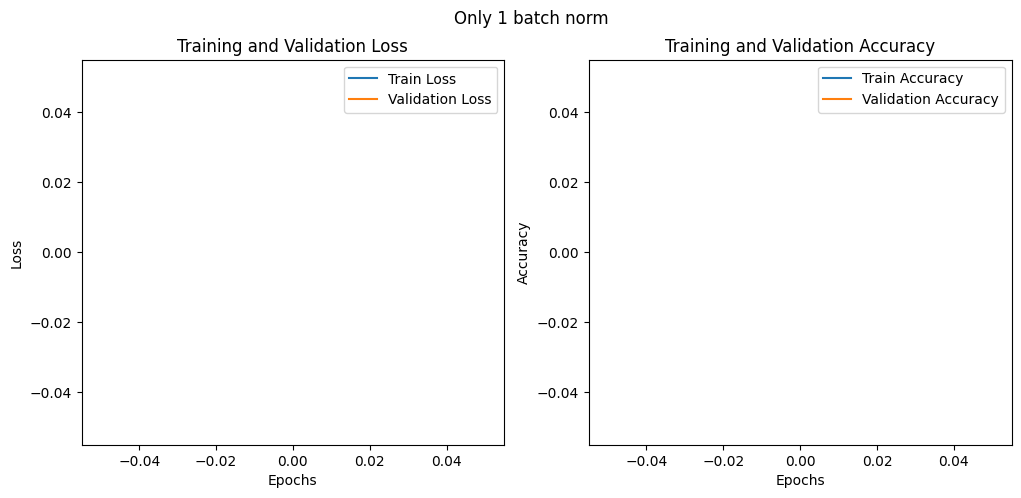

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation losses on the left side
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracies on the right side
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('Only 1 batch norm')
plt.show()

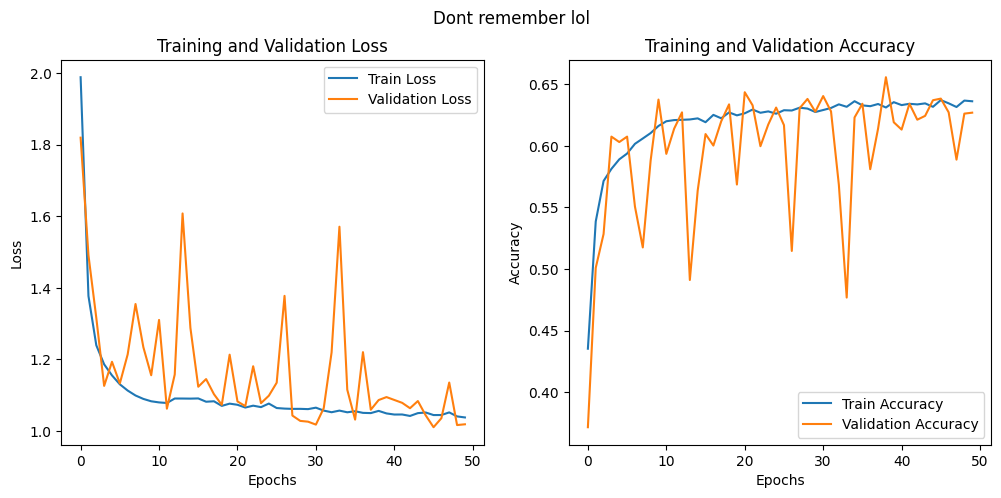

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation losses on the left side
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracies on the right side
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('Dont remember lol')
plt.show()

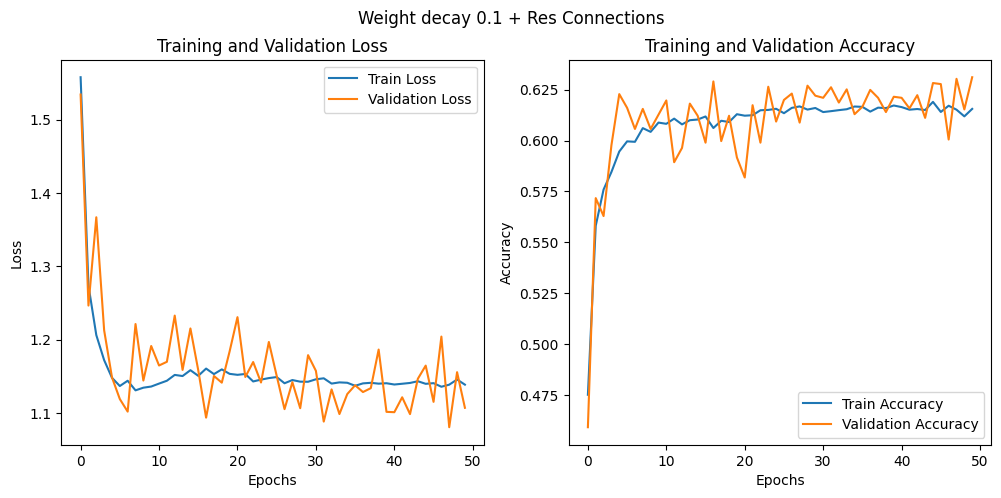

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation losses on the left side
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracies on the right side
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('Weight decay 0.1 + Res Connections')
plt.show()

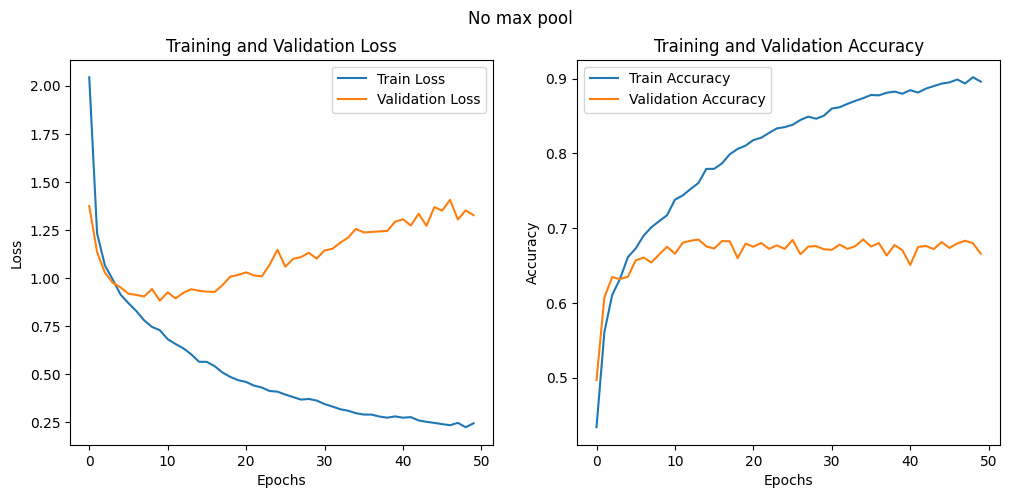

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation losses on the left side
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracies on the right side
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('No max pool')
plt.show()

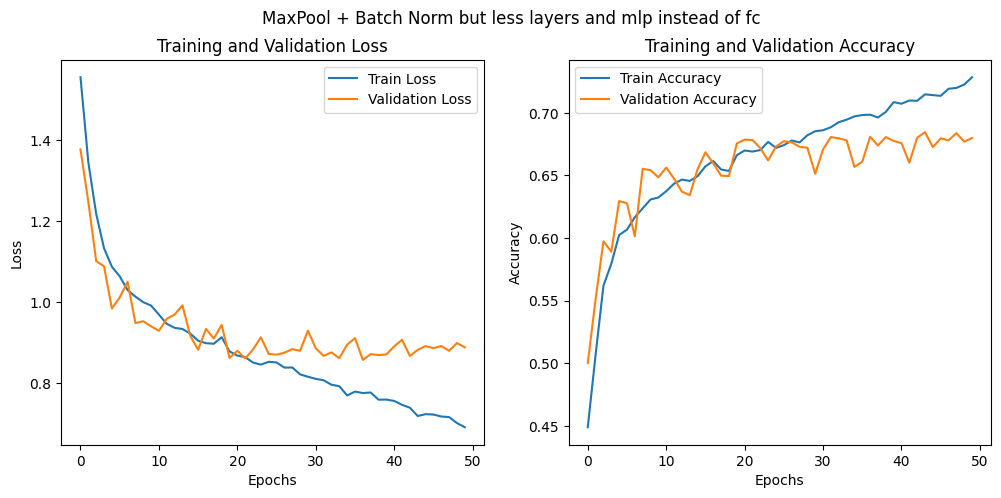

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation losses on the left side
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracies on the right side
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('MaxPool + Batch Norm but less layers and mlp instead of fc')
plt.show()

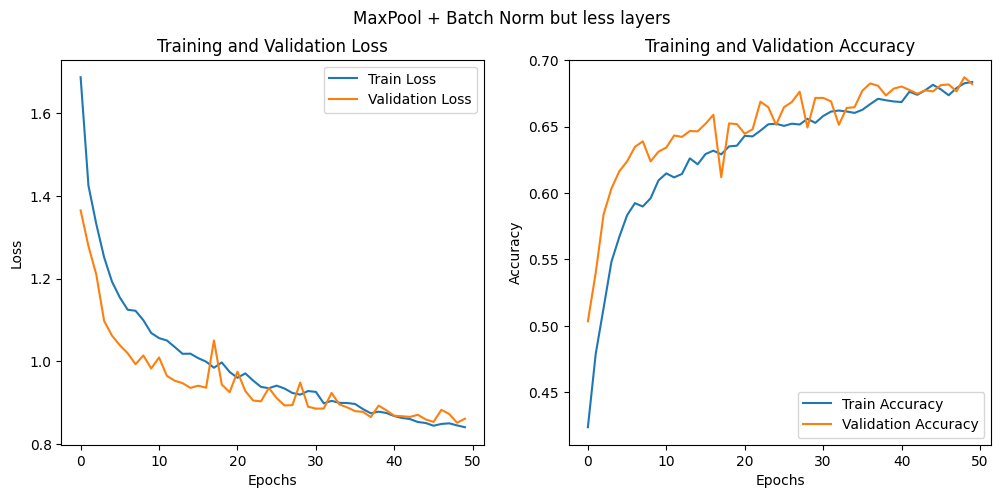

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation losses on the left side
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracies on the right side
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('MaxPool + Batch Norm but less layers')
plt.show()

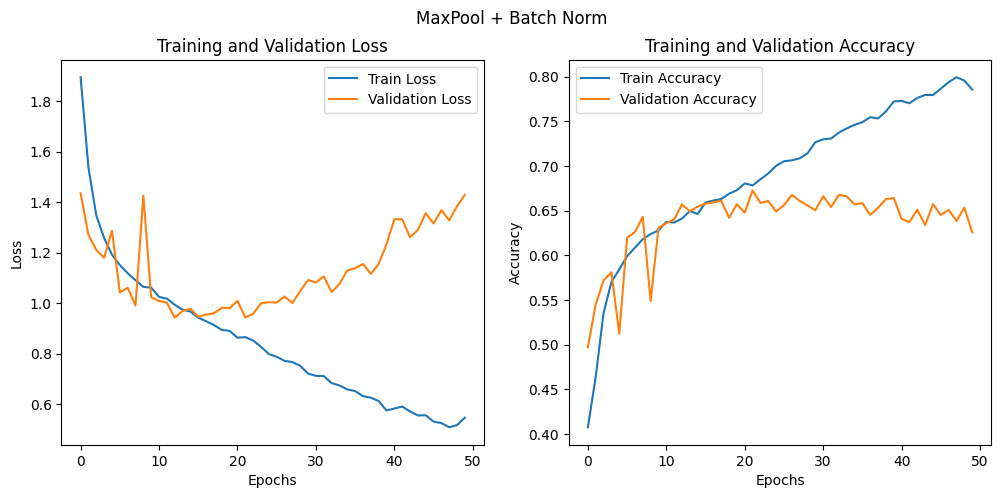

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation losses on the left side
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracies on the right side
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('MaxPool + Batch Norm')
plt.show()

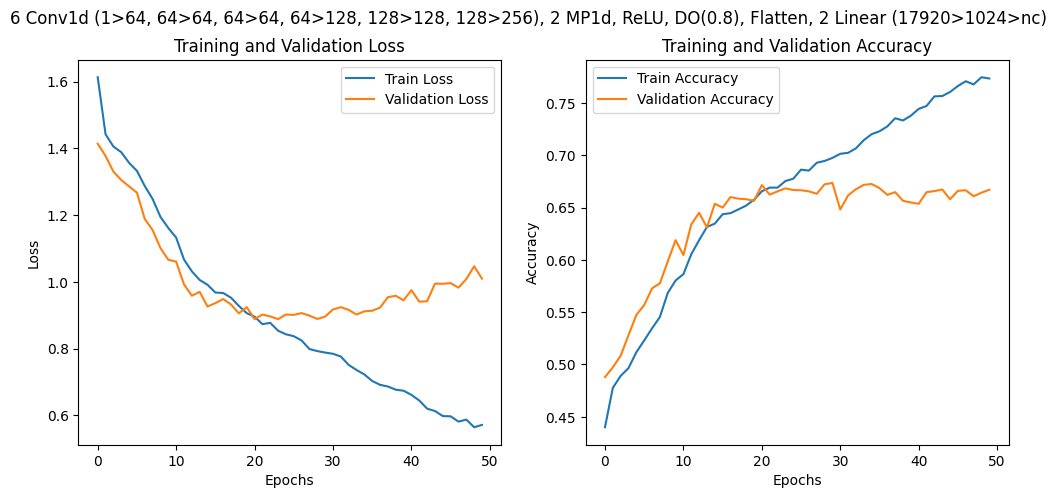

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation losses on the left side
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracies on the right side
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('6 Conv1d (1>64, 64>64, 64>64, 64>128, 128>128, 128>256), 2 MP1d, ReLU, DO(0.8), Flatten, 2 Linear (17920>1024>nc)')
plt.show()

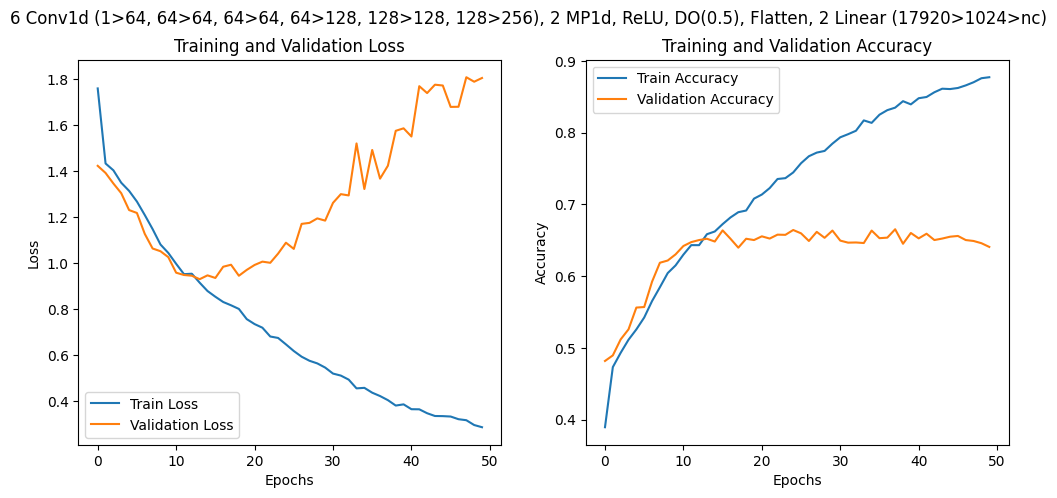

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation losses on the left side
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracies on the right side
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle('6 Conv1d (1>64, 64>64, 64>64, 64>128, 128>128, 128>256), 2 MP1d, ReLU, DO(0.5), Flatten, 2 Linear (17920>1024>nc)')
plt.show()

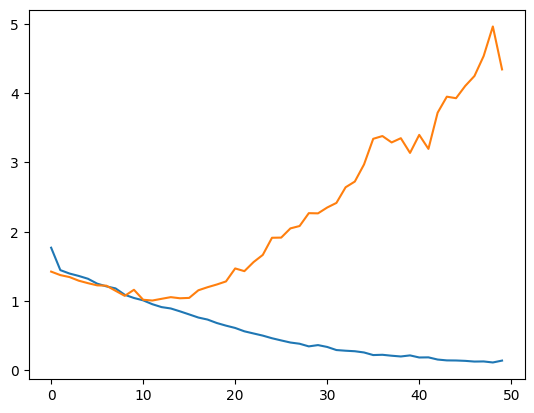

In [48]:
plt.plot(train_losses)
plt.plot(val_losses)

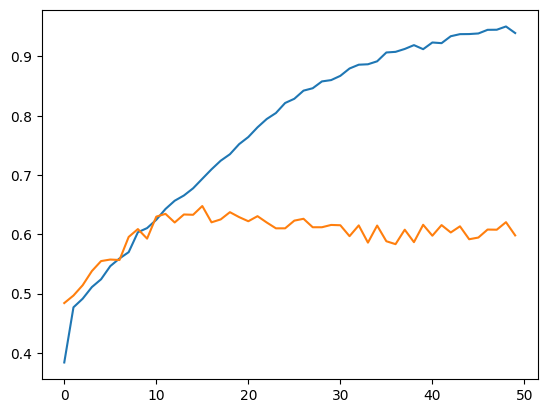

In [49]:
plt.plot(train_accs)
plt.plot(val_accs)

In [47]:
for i in range(10, 50):
    print(f'Epoch {i}')
    
    train_loss, train_acc = train_epoch()
    print(f'Train Loss: {round(train_loss, 3)} Acc: {round(train_acc, 2)}')
    
    val_loss, val_acc = val_epoch()
    print(f'Val Loss: {round(val_loss, 3)} Acc: {round(val_acc, 2)}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

Epoch 10


100%|████████████████████████████████████████████████████████| 36/36 [00:50<00:00,  1.41s/it]


Train Loss: 1.009 Acc: 0.62


100%|██████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.32s/it]


Val Loss: 1.017 Acc: 0.63
Epoch 11


100%|████████████████████████████████████████████████████████| 36/36 [00:44<00:00,  1.24s/it]


Train Loss: 0.953 Acc: 0.64


100%|██████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.34s/it]


Val Loss: 1.006 Acc: 0.63
Epoch 12


100%|████████████████████████████████████████████████████████| 36/36 [00:54<00:00,  1.50s/it]


Train Loss: 0.85 Acc: 0.68


100%|██████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.72s/it]


Val Loss: 1.039 Acc: 0.63
Epoch 15


100%|████████████████████████████████████████████████████████| 36/36 [01:00<00:00,  1.69s/it]


Train Loss: 0.805 Acc: 0.69


100%|██████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.79s/it]


Val Loss: 1.044 Acc: 0.65
Epoch 16


100%|████████████████████████████████████████████████████████| 36/36 [00:57<00:00,  1.58s/it]


Train Loss: 0.76 Acc: 0.71


100%|██████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.78s/it]


Val Loss: 1.154 Acc: 0.62
Epoch 17


100%|████████████████████████████████████████████████████████| 36/36 [00:57<00:00,  1.61s/it]


Train Loss: 0.731 Acc: 0.72


100%|██████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.57s/it]


Val Loss: 1.198 Acc: 0.63
Epoch 18


100%|████████████████████████████████████████████████████████| 36/36 [00:58<00:00,  1.62s/it]


Train Loss: 0.681 Acc: 0.74


100%|██████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.67s/it]


Val Loss: 1.237 Acc: 0.64
Epoch 19


100%|████████████████████████████████████████████████████████| 36/36 [00:58<00:00,  1.63s/it]


Train Loss: 0.643 Acc: 0.75


100%|██████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.62s/it]


Val Loss: 1.282 Acc: 0.63
Epoch 20


100%|████████████████████████████████████████████████████████| 36/36 [00:52<00:00,  1.46s/it]


Train Loss: 0.61 Acc: 0.76


100%|██████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  1.88s/it]


Val Loss: 1.469 Acc: 0.62
Epoch 21


100%|████████████████████████████████████████████████████████| 36/36 [00:55<00:00,  1.53s/it]


Train Loss: 0.561 Acc: 0.78


100%|██████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.69s/it]


Val Loss: 1.43 Acc: 0.63
Epoch 22


100%|████████████████████████████████████████████████████████| 36/36 [00:58<00:00,  1.62s/it]


Train Loss: 0.53 Acc: 0.79


100%|██████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.76s/it]


Val Loss: 1.562 Acc: 0.62
Epoch 23


100%|████████████████████████████████████████████████████████| 36/36 [01:00<00:00,  1.69s/it]


Train Loss: 0.499 Acc: 0.8


100%|██████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.66s/it]


Val Loss: 1.665 Acc: 0.61
Epoch 24


100%|████████████████████████████████████████████████████████| 36/36 [01:02<00:00,  1.73s/it]


Train Loss: 0.461 Acc: 0.82


100%|██████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.70s/it]


Val Loss: 1.913 Acc: 0.61
Epoch 25


100%|████████████████████████████████████████████████████████| 36/36 [00:56<00:00,  1.57s/it]


Train Loss: 0.43 Acc: 0.83


100%|██████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.85s/it]


Val Loss: 1.915 Acc: 0.62
Epoch 26


100%|████████████████████████████████████████████████████████| 36/36 [00:59<00:00,  1.65s/it]


Train Loss: 0.4 Acc: 0.84


100%|██████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.68s/it]


Val Loss: 2.048 Acc: 0.63
Epoch 27


100%|████████████████████████████████████████████████████████| 36/36 [00:58<00:00,  1.63s/it]


Train Loss: 0.382 Acc: 0.85


100%|██████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.48s/it]


Val Loss: 2.082 Acc: 0.61
Epoch 28


100%|████████████████████████████████████████████████████████| 36/36 [00:55<00:00,  1.54s/it]


Train Loss: 0.344 Acc: 0.86


100%|██████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.49s/it]


Val Loss: 2.268 Acc: 0.61
Epoch 29


100%|████████████████████████████████████████████████████████| 36/36 [00:56<00:00,  1.58s/it]


Train Loss: 0.362 Acc: 0.86


100%|██████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.83s/it]


Val Loss: 2.265 Acc: 0.62
Epoch 30


100%|████████████████████████████████████████████████████████| 36/36 [01:01<00:00,  1.70s/it]


Train Loss: 0.336 Acc: 0.87


100%|██████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  1.92s/it]


Val Loss: 2.349 Acc: 0.62
Epoch 31


100%|████████████████████████████████████████████████████████| 36/36 [00:58<00:00,  1.63s/it]


Train Loss: 0.291 Acc: 0.88


100%|██████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.71s/it]


Val Loss: 2.416 Acc: 0.6
Epoch 32


100%|████████████████████████████████████████████████████████| 36/36 [00:54<00:00,  1.50s/it]


Train Loss: 0.281 Acc: 0.89


100%|██████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.55s/it]


Val Loss: 2.642 Acc: 0.62
Epoch 33


100%|████████████████████████████████████████████████████████| 36/36 [00:59<00:00,  1.64s/it]


Train Loss: 0.274 Acc: 0.89


100%|██████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.57s/it]


Val Loss: 2.724 Acc: 0.59
Epoch 34


100%|████████████████████████████████████████████████████████| 36/36 [00:59<00:00,  1.66s/it]


Train Loss: 0.256 Acc: 0.89


100%|██████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.38s/it]


Val Loss: 2.971 Acc: 0.61
Epoch 35


100%|████████████████████████████████████████████████████████| 36/36 [00:50<00:00,  1.40s/it]


Train Loss: 0.218 Acc: 0.91


100%|██████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.29s/it]


Val Loss: 3.342 Acc: 0.59
Epoch 36


100%|████████████████████████████████████████████████████████| 36/36 [00:49<00:00,  1.39s/it]


Train Loss: 0.222 Acc: 0.91


100%|██████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.43s/it]


Val Loss: 3.382 Acc: 0.58
Epoch 37


100%|████████████████████████████████████████████████████████| 36/36 [00:48<00:00,  1.35s/it]


Train Loss: 0.209 Acc: 0.91


100%|██████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.32s/it]


Val Loss: 3.289 Acc: 0.61
Epoch 38


100%|████████████████████████████████████████████████████████| 36/36 [00:49<00:00,  1.38s/it]


Train Loss: 0.198 Acc: 0.92


100%|██████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.31s/it]


Val Loss: 3.35 Acc: 0.59
Epoch 39


100%|████████████████████████████████████████████████████████| 36/36 [00:48<00:00,  1.34s/it]


Train Loss: 0.214 Acc: 0.91


100%|██████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.34s/it]


Val Loss: 3.138 Acc: 0.62
Epoch 40


100%|████████████████████████████████████████████████████████| 36/36 [00:58<00:00,  1.62s/it]


Train Loss: 0.183 Acc: 0.92


100%|██████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.76s/it]


Val Loss: 3.398 Acc: 0.6
Epoch 41


100%|████████████████████████████████████████████████████████| 36/36 [00:55<00:00,  1.55s/it]


Train Loss: 0.185 Acc: 0.92


100%|██████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.82s/it]


Val Loss: 3.196 Acc: 0.62
Epoch 42


100%|████████████████████████████████████████████████████████| 36/36 [00:58<00:00,  1.61s/it]


Train Loss: 0.154 Acc: 0.93


100%|██████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.57s/it]


Val Loss: 3.719 Acc: 0.6
Epoch 43


100%|████████████████████████████████████████████████████████| 36/36 [00:59<00:00,  1.64s/it]


Train Loss: 0.141 Acc: 0.94


100%|██████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.56s/it]


Val Loss: 3.95 Acc: 0.61
Epoch 44


100%|████████████████████████████████████████████████████████| 36/36 [01:00<00:00,  1.69s/it]


Train Loss: 0.14 Acc: 0.94


100%|██████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.54s/it]


Val Loss: 3.928 Acc: 0.59
Epoch 45


100%|████████████████████████████████████████████████████████| 36/36 [00:47<00:00,  1.32s/it]


Train Loss: 0.135 Acc: 0.94


100%|██████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.40s/it]


Val Loss: 4.105 Acc: 0.59
Epoch 46


100%|████████████████████████████████████████████████████████| 36/36 [00:45<00:00,  1.26s/it]


Train Loss: 0.125 Acc: 0.94


100%|██████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.35s/it]


Val Loss: 4.249 Acc: 0.61
Epoch 47


100%|████████████████████████████████████████████████████████| 36/36 [00:51<00:00,  1.43s/it]


Train Loss: 0.126 Acc: 0.95


100%|██████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.43s/it]


Val Loss: 4.537 Acc: 0.61
Epoch 48


100%|████████████████████████████████████████████████████████| 36/36 [00:47<00:00,  1.33s/it]


Train Loss: 0.111 Acc: 0.95


100%|██████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.36s/it]


Val Loss: 4.964 Acc: 0.62
Epoch 49


100%|████████████████████████████████████████████████████████| 36/36 [00:49<00:00,  1.37s/it]


Train Loss: 0.139 Acc: 0.94


100%|██████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.53s/it]

Val Loss: 4.344 Acc: 0.6


In [7]:
datapath = Path('/home/mariia/AstroML/data/asassn')
ds_train = ASASSNVarStarDataset(datapath, mode='train', verbose=True, only_periodic=True, recalc_period=False, 
                                prime=True, use_bands=['v', 'g'], only_sources_with_spectra=True, return_phased=True, 
                                fill_value=0)

Opening v data files... Found 687695 sources. done.
Opening g data files... Found 378861 sources. done.
Opening spectra csv... done.
Keeping only v band sources with spectra... Left with 26401 sources. done.
Keeping only g band sources with spectra... Left with 25954 sources. done.
Removing duplicates for v band... Left with 25950. done.
Removing duplicates for g band... Left with 25950. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for v band... Left with 22680. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for g band... Left with 25536. done.
Merging bands... done. Now 22447 sources.
Removed non-periodic sources. Now 22447 sources.
Total: 22447, Train: 17957, Val: 2244, Test: 2246
Priming tarballs by doing initial scan... done.


In [9]:
ds_val = ASASSNVarStarDataset(datapath, mode='val', verbose=True, only_periodic=True, recalc_period=False, 
                              prime=True, use_bands=['v', 'g'], only_sources_with_spectra=True, return_phased=True, 
                              fill_value=0)

Opening v data files... Found 687695 sources. done.
Opening g data files... Found 378861 sources. done.
Opening spectra csv... done.
Keeping only v band sources with spectra... Left with 26401 sources. done.
Keeping only g band sources with spectra... Left with 25954 sources. done.
Removing duplicates for v band... Left with 25950. done.
Removing duplicates for g band... Left with 25950. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for v band... Left with 22680. done.
Removing objects that have class different from ['CWA', 'CWB', 'DCEP', 'DCEPS', 'DSCT', 'EA', 'EB', 'EW', 'HADS', 'M', 'ROT', 'RRAB', 'RRC', 'RRD', 'RVA', 'SR'] for g band... Left with 25536. done.
Merging bands... done. Now 22447 sources.
Removed non-periodic sources. Now 22447 sources.
Total: 22447, Train: 17957, Val: 2244, Test: 2246
Priming tarballs by doing initial scan... done.


In [ ]:
def preprocess_batch(batch, masks):
    lcs, classes = batch
    lcs_mask, classes_mask = masks

    # shape now [128, 1, 3, 759], make [128, 3, 759] 
    X = lcs[:, 0, :, :]
    
    # change axises, shape now [128, 3, 759], make [128, 759, 3]
    X = X.transpose(1, 2)
    
    # since mask is the same for time flux and flux err we can make it 2D
    mask = lcs_mask[:, 0, 0, :]

    # context length 200, crop X and MASK if longer, pad if shorter
    if X.shape[1] < context_length:
        X_padding = (0, 0, 0, context_length - X.shape[1], 0, 0)
        mask_padding = (0, context_length - X.shape[1])
        X = F.pad(X, X_padding)
        mask = F.pad(mask, mask_padding, value=True)
    else:
        X = X[:, :context_length, :]
        mask = mask[:, :context_length]

    # the last dimention is (time, flux, flux_err), sort it based on time
    sort_indices = torch.argsort(X[:, :, 0], dim=1)
    sorted_X = torch.zeros_like(X)
    
    for i in range(X.shape[0]):
        sorted_X[i] = X[i, sort_indices[i]]
    
    # rearange indexes for masks as well
    sorted_mask = torch.zeros_like(mask)
    
    for i in range(mask.shape[0]):
        sorted_mask[i] = mask[i, sort_indices[i]]

    # mask should be 1 for values that are observed and 0 for values that are missing
    sorted_mask = 1 - sorted_mask.int()

    # read scales
    with open('scales.json', 'r') as f:
        scales = json.load(f)
        mean, std = scales['v']['mean'], scales['v']['std']

    # scale X
    sorted_X[:, :, 1] = (sorted_X[:, :, 1] - mean) / std
    sorted_X[:, :, 2] = sorted_X[:, :, 2] / std

    # reshape classes to be 1D vector and convert from float to int
    classes = classes[:, 0]
    classes = classes.long()
    
    return sorted_X, sorted_mask, classes

In [12]:
train_dataset = SpectraDataset(ds_train)
val_dataset = SpectraDataset(ds_val)

In [13]:
train_dataset[0]

(array([[1.7747896, 2.0907125, 2.5059266, ..., 1.3947029, 1.4395491,
         1.4337945]], dtype=float32),
 12)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [15]:
class GalSpecNet(nn.Module):
    """https://academic.oup.com/mnras/article/527/1/1163/7283157"""
    
    def __init__(self, num_classes):
        super(GalSpecNet, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=0)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=0)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=0)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=0)

        self.mp1 = nn.MaxPool1d(kernel_size=4)
        self.mp2 = nn.MaxPool1d(kernel_size=4)
        self.mp3 = nn.MaxPool1d(kernel_size=4)

        self.fc1 = nn.Linear(2496, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.mp1(self.conv1(x)))
        x = F.relu(self.mp2(self.conv2(x)))
        x = F.relu(self.mp3(self.conv3(x)))
        x = F.relu(self.conv4(x))        
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [18]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print('Using', device)

Using cuda:2


In [19]:
model = GalSpecNet(len(ds_train.target_lookup))
model = model.to(device)

In [20]:
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [22]:
def train_epoch():
    model.train()
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    for fluxes, label in tqdm(train_dataloader):
        fluxes, label = fluxes.to(device), label.to(device)

        optimizer.zero_grad()

        logits = model(fluxes)
        loss = criterion(logits, label)
        total_loss.append(loss.item())

        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == label).sum().item()

        total_correct_predictions += correct_predictions
        total_predictions += label.size(0)

        loss.backward()
        optimizer.step()

    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions

In [23]:
def val_epoch():
    model.eval()
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for fluxes, label in tqdm(val_dataloader):
            fluxes, label = fluxes.to(device), label.to(device)

            logits = model(fluxes)
            loss = criterion(logits, label)
            total_loss.append(loss.item())

            probabilities = torch.nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            correct_predictions = (predicted_labels == label).sum().item()
    
            total_correct_predictions += correct_predictions
            total_predictions += label.size(0)

    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions

In [24]:
for i in range(10):
    print(f'Epoch {i}')
    
    train_loss, train_acc = train_epoch()
    print(f'Train Loss: {round(train_loss, 3)} Acc: {round(train_acc, 2)}')
    
    val_loss, val_acc = val_epoch()
    print(f'Val Loss: {round(val_loss, 3)} Acc: {round(val_acc, 2)}')

Epoch 0


100%|███████████████████████████████████████████| 36/36 [07:39<00:00, 12.76s/it]


Train Loss: 1.826 Acc: 0.42


100%|█████████████████████████████████████████████| 5/5 [02:41<00:00, 32.25s/it]


Val Loss: 1.43 Acc: 0.5
Epoch 1


100%|███████████████████████████████████████████| 36/36 [10:55<00:00, 18.22s/it]


Train Loss: 1.347 Acc: 0.52


100%|█████████████████████████████████████████████| 5/5 [06:05<00:00, 73.16s/it]


Val Loss: 1.299 Acc: 0.53
Epoch 2


100%|███████████████████████████████████████████| 36/36 [15:59<00:00, 26.64s/it]


Train Loss: 1.276 Acc: 0.54


100%|█████████████████████████████████████████████| 5/5 [06:10<00:00, 74.10s/it]


Val Loss: 1.268 Acc: 0.54
Epoch 3


100%|███████████████████████████████████████████| 36/36 [14:03<00:00, 23.44s/it]


Train Loss: 1.237 Acc: 0.55


100%|█████████████████████████████████████████████| 5/5 [05:21<00:00, 64.35s/it]


Val Loss: 1.267 Acc: 0.55
Epoch 4


100%|███████████████████████████████████████████| 36/36 [14:25<00:00, 24.04s/it]


Train Loss: 1.213 Acc: 0.57


100%|█████████████████████████████████████████████| 5/5 [06:16<00:00, 75.32s/it]


Val Loss: 1.164 Acc: 0.58
Epoch 5


100%|███████████████████████████████████████████| 36/36 [14:00<00:00, 23.34s/it]


Train Loss: 1.179 Acc: 0.58


100%|█████████████████████████████████████████████| 5/5 [05:07<00:00, 61.49s/it]


Val Loss: 1.156 Acc: 0.58
Epoch 6


100%|███████████████████████████████████████████| 36/36 [09:49<00:00, 16.36s/it]


Train Loss: 1.131 Acc: 0.59


100%|█████████████████████████████████████████████| 5/5 [02:02<00:00, 24.48s/it]


Val Loss: 1.112 Acc: 0.61
Epoch 7


100%|███████████████████████████████████████████| 36/36 [05:39<00:00,  9.42s/it]


Train Loss: 1.082 Acc: 0.61


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.99s/it]


Val Loss: 1.076 Acc: 0.61
Epoch 8


100%|███████████████████████████████████████████| 36/36 [04:17<00:00,  7.17s/it]


Train Loss: 1.031 Acc: 0.63


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.95s/it]


Val Loss: 1.006 Acc: 0.63
Epoch 9


100%|███████████████████████████████████████████| 36/36 [04:23<00:00,  7.33s/it]


Train Loss: 0.969 Acc: 0.65


100%|█████████████████████████████████████████████| 5/5 [01:57<00:00, 23.47s/it]

Val Loss: 0.966 Acc: 0.65


In [25]:
for i in range(10, 100):
    print(f'Epoch {i}')
    
    train_loss, train_acc = train_epoch()
    print(f'Train Loss: {round(train_loss, 3)} Acc: {round(train_acc, 2)}')
    
    val_loss, val_acc = val_epoch()
    print(f'Val Loss: {round(val_loss, 3)} Acc: {round(val_acc, 2)}')

Epoch 10


100%|███████████████████████████████████████████| 36/36 [04:42<00:00,  7.85s/it]


Train Loss: 0.922 Acc: 0.67


100%|█████████████████████████████████████████████| 5/5 [01:53<00:00, 22.67s/it]


Val Loss: 0.987 Acc: 0.64
Epoch 11


100%|███████████████████████████████████████████| 36/36 [04:24<00:00,  7.34s/it]


Train Loss: 0.887 Acc: 0.68


100%|█████████████████████████████████████████████| 5/5 [01:52<00:00, 22.58s/it]


Val Loss: 0.875 Acc: 0.68
Epoch 12


100%|███████████████████████████████████████████| 36/36 [05:50<00:00,  9.73s/it]


Train Loss: 0.847 Acc: 0.7


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.84s/it]


Val Loss: 0.826 Acc: 0.69
Epoch 13


100%|███████████████████████████████████████████| 36/36 [04:46<00:00,  7.95s/it]


Train Loss: 0.82 Acc: 0.71


100%|█████████████████████████████████████████████| 5/5 [02:00<00:00, 24.10s/it]


Val Loss: 0.843 Acc: 0.69
Epoch 14


100%|███████████████████████████████████████████| 36/36 [05:04<00:00,  8.47s/it]


Train Loss: 0.797 Acc: 0.71


100%|█████████████████████████████████████████████| 5/5 [01:55<00:00, 23.17s/it]


Val Loss: 0.872 Acc: 0.68
Epoch 15


100%|███████████████████████████████████████████| 36/36 [05:02<00:00,  8.40s/it]


Train Loss: 0.776 Acc: 0.73


100%|█████████████████████████████████████████████| 5/5 [01:56<00:00, 23.30s/it]


Val Loss: 0.842 Acc: 0.7
Epoch 16


100%|███████████████████████████████████████████| 36/36 [04:37<00:00,  7.70s/it]


Train Loss: 0.758 Acc: 0.72


100%|█████████████████████████████████████████████| 5/5 [01:58<00:00, 23.75s/it]


Val Loss: 0.789 Acc: 0.72
Epoch 17


100%|███████████████████████████████████████████| 36/36 [04:20<00:00,  7.24s/it]


Train Loss: 0.742 Acc: 0.73


100%|█████████████████████████████████████████████| 5/5 [01:58<00:00, 23.75s/it]


Val Loss: 0.836 Acc: 0.71
Epoch 18


100%|███████████████████████████████████████████| 36/36 [05:25<00:00,  9.04s/it]


Train Loss: 0.735 Acc: 0.74


100%|█████████████████████████████████████████████| 5/5 [01:59<00:00, 23.88s/it]


Val Loss: 0.768 Acc: 0.72
Epoch 19


100%|███████████████████████████████████████████| 36/36 [04:38<00:00,  7.73s/it]


Train Loss: 0.715 Acc: 0.74


100%|█████████████████████████████████████████████| 5/5 [02:01<00:00, 24.23s/it]


Val Loss: 0.764 Acc: 0.73
Epoch 20


100%|███████████████████████████████████████████| 36/36 [04:42<00:00,  7.86s/it]


Train Loss: 0.722 Acc: 0.74


100%|█████████████████████████████████████████████| 5/5 [01:59<00:00, 23.85s/it]


Val Loss: 0.763 Acc: 0.72
Epoch 21


100%|███████████████████████████████████████████| 36/36 [04:23<00:00,  7.31s/it]


Train Loss: 0.712 Acc: 0.74


100%|█████████████████████████████████████████████| 5/5 [01:56<00:00, 23.26s/it]


Val Loss: 0.761 Acc: 0.73
Epoch 22


100%|███████████████████████████████████████████| 36/36 [05:40<00:00,  9.47s/it]


Train Loss: 0.689 Acc: 0.75


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.94s/it]


Val Loss: 0.741 Acc: 0.73
Epoch 23


100%|███████████████████████████████████████████| 36/36 [05:17<00:00,  8.82s/it]


Train Loss: 0.67 Acc: 0.76


100%|█████████████████████████████████████████████| 5/5 [01:56<00:00, 23.40s/it]


Val Loss: 0.742 Acc: 0.74
Epoch 24


100%|███████████████████████████████████████████| 36/36 [04:44<00:00,  7.92s/it]


Train Loss: 0.663 Acc: 0.76


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.94s/it]


Val Loss: 0.748 Acc: 0.74
Epoch 25


100%|███████████████████████████████████████████| 36/36 [04:51<00:00,  8.11s/it]


Train Loss: 0.664 Acc: 0.76


100%|█████████████████████████████████████████████| 5/5 [01:56<00:00, 23.38s/it]


Val Loss: 0.729 Acc: 0.73
Epoch 26


100%|███████████████████████████████████████████| 36/36 [05:10<00:00,  8.64s/it]


Train Loss: 0.663 Acc: 0.76


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.95s/it]


Val Loss: 0.73 Acc: 0.74
Epoch 27


100%|███████████████████████████████████████████| 36/36 [05:17<00:00,  8.83s/it]


Train Loss: 0.644 Acc: 0.77


100%|█████████████████████████████████████████████| 5/5 [02:00<00:00, 24.07s/it]


Val Loss: 0.728 Acc: 0.74
Epoch 28


100%|███████████████████████████████████████████| 36/36 [04:39<00:00,  7.75s/it]


Train Loss: 0.624 Acc: 0.77


100%|█████████████████████████████████████████████| 5/5 [02:00<00:00, 24.05s/it]


Val Loss: 0.751 Acc: 0.74
Epoch 29


100%|███████████████████████████████████████████| 36/36 [04:32<00:00,  7.58s/it]


Train Loss: 0.622 Acc: 0.77


100%|█████████████████████████████████████████████| 5/5 [02:00<00:00, 24.01s/it]


Val Loss: 0.726 Acc: 0.74
Epoch 30


100%|███████████████████████████████████████████| 36/36 [05:27<00:00,  9.09s/it]


Train Loss: 0.607 Acc: 0.78


100%|█████████████████████████████████████████████| 5/5 [01:58<00:00, 23.68s/it]


Val Loss: 0.734 Acc: 0.74
Epoch 31


100%|███████████████████████████████████████████| 36/36 [05:52<00:00,  9.80s/it]


Train Loss: 0.599 Acc: 0.78


100%|█████████████████████████████████████████████| 5/5 [01:57<00:00, 23.46s/it]


Val Loss: 0.74 Acc: 0.73
Epoch 32


100%|███████████████████████████████████████████| 36/36 [04:37<00:00,  7.72s/it]


Train Loss: 0.603 Acc: 0.78


100%|█████████████████████████████████████████████| 5/5 [01:58<00:00, 23.79s/it]


Val Loss: 0.729 Acc: 0.73
Epoch 33


100%|███████████████████████████████████████████| 36/36 [05:21<00:00,  8.93s/it]


Train Loss: 0.578 Acc: 0.79


100%|█████████████████████████████████████████████| 5/5 [01:56<00:00, 23.35s/it]


Val Loss: 0.72 Acc: 0.75
Epoch 34


100%|███████████████████████████████████████████| 36/36 [04:20<00:00,  7.23s/it]


Train Loss: 0.585 Acc: 0.79


100%|█████████████████████████████████████████████| 5/5 [01:57<00:00, 23.40s/it]


Val Loss: 0.767 Acc: 0.73
Epoch 35


100%|███████████████████████████████████████████| 36/36 [04:58<00:00,  8.28s/it]


Train Loss: 0.571 Acc: 0.79


100%|█████████████████████████████████████████████| 5/5 [01:55<00:00, 23.01s/it]


Val Loss: 0.733 Acc: 0.74
Epoch 36


100%|███████████████████████████████████████████| 36/36 [04:18<00:00,  7.18s/it]


Train Loss: 0.566 Acc: 0.79


100%|█████████████████████████████████████████████| 5/5 [01:55<00:00, 23.08s/it]


Val Loss: 0.766 Acc: 0.73
Epoch 37


100%|███████████████████████████████████████████| 36/36 [05:24<00:00,  9.03s/it]


Train Loss: 0.56 Acc: 0.8


100%|█████████████████████████████████████████████| 5/5 [01:58<00:00, 23.78s/it]


Val Loss: 0.778 Acc: 0.73
Epoch 38


100%|███████████████████████████████████████████| 36/36 [05:23<00:00,  8.99s/it]


Train Loss: 0.557 Acc: 0.79


100%|█████████████████████████████████████████████| 5/5 [01:57<00:00, 23.50s/it]


Val Loss: 0.768 Acc: 0.73
Epoch 39


100%|███████████████████████████████████████████| 36/36 [03:39<00:00,  6.08s/it]


Train Loss: 0.545 Acc: 0.8


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.90s/it]


Val Loss: 0.792 Acc: 0.72
Epoch 40


100%|███████████████████████████████████████████| 36/36 [04:54<00:00,  8.18s/it]


Train Loss: 0.518 Acc: 0.81


100%|█████████████████████████████████████████████| 5/5 [01:55<00:00, 23.01s/it]


Val Loss: 0.761 Acc: 0.74
Epoch 41


100%|███████████████████████████████████████████| 36/36 [04:32<00:00,  7.57s/it]


Train Loss: 0.515 Acc: 0.81


100%|█████████████████████████████████████████████| 5/5 [01:56<00:00, 23.35s/it]


Val Loss: 0.788 Acc: 0.75
Epoch 42


100%|███████████████████████████████████████████| 36/36 [04:14<00:00,  7.08s/it]


Train Loss: 0.531 Acc: 0.8


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.84s/it]


Val Loss: 0.79 Acc: 0.75
Epoch 43


100%|███████████████████████████████████████████| 36/36 [05:15<00:00,  8.77s/it]


Train Loss: 0.511 Acc: 0.81


100%|█████████████████████████████████████████████| 5/5 [01:55<00:00, 23.06s/it]


Val Loss: 0.776 Acc: 0.74
Epoch 44


100%|███████████████████████████████████████████| 36/36 [04:25<00:00,  7.36s/it]


Train Loss: 0.511 Acc: 0.81


100%|█████████████████████████████████████████████| 5/5 [01:57<00:00, 23.45s/it]


Val Loss: 0.771 Acc: 0.74
Epoch 45


100%|███████████████████████████████████████████| 36/36 [05:08<00:00,  8.57s/it]


Train Loss: 0.495 Acc: 0.82


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.96s/it]


Val Loss: 0.782 Acc: 0.74
Epoch 46


100%|███████████████████████████████████████████| 36/36 [04:58<00:00,  8.28s/it]


Train Loss: 0.488 Acc: 0.82


100%|█████████████████████████████████████████████| 5/5 [01:55<00:00, 23.17s/it]


Val Loss: 0.801 Acc: 0.74
Epoch 47


100%|███████████████████████████████████████████| 36/36 [04:51<00:00,  8.09s/it]


Train Loss: 0.473 Acc: 0.83


100%|█████████████████████████████████████████████| 5/5 [01:56<00:00, 23.26s/it]


Val Loss: 0.786 Acc: 0.75
Epoch 48


100%|███████████████████████████████████████████| 36/36 [05:13<00:00,  8.72s/it]


Train Loss: 0.465 Acc: 0.83


100%|█████████████████████████████████████████████| 5/5 [01:59<00:00, 23.89s/it]


Val Loss: 0.819 Acc: 0.73
Epoch 49


100%|███████████████████████████████████████████| 36/36 [04:37<00:00,  7.71s/it]


Train Loss: 0.483 Acc: 0.82


100%|█████████████████████████████████████████████| 5/5 [01:56<00:00, 23.39s/it]


Val Loss: 0.845 Acc: 0.73
Epoch 50


100%|███████████████████████████████████████████| 36/36 [05:06<00:00,  8.50s/it]


Train Loss: 0.472 Acc: 0.83


100%|█████████████████████████████████████████████| 5/5 [01:55<00:00, 23.08s/it]


Val Loss: 0.94 Acc: 0.68
Epoch 51


100%|███████████████████████████████████████████| 36/36 [04:19<00:00,  7.22s/it]


Train Loss: 0.477 Acc: 0.82


100%|█████████████████████████████████████████████| 5/5 [01:58<00:00, 23.70s/it]


Val Loss: 0.84 Acc: 0.73
Epoch 52


100%|███████████████████████████████████████████| 36/36 [04:21<00:00,  7.27s/it]


Train Loss: 0.446 Acc: 0.84


100%|█████████████████████████████████████████████| 5/5 [01:57<00:00, 23.51s/it]


Val Loss: 0.866 Acc: 0.73
Epoch 53


100%|███████████████████████████████████████████| 36/36 [04:39<00:00,  7.77s/it]


Train Loss: 0.437 Acc: 0.84


100%|█████████████████████████████████████████████| 5/5 [01:55<00:00, 23.05s/it]


Val Loss: 0.89 Acc: 0.73
Epoch 54


100%|███████████████████████████████████████████| 36/36 [03:51<00:00,  6.43s/it]


Train Loss: 0.438 Acc: 0.84


100%|█████████████████████████████████████████████| 5/5 [01:55<00:00, 23.08s/it]


Val Loss: 0.93 Acc: 0.71
Epoch 55


100%|███████████████████████████████████████████| 36/36 [05:05<00:00,  8.47s/it]


Train Loss: 0.419 Acc: 0.84


100%|█████████████████████████████████████████████| 5/5 [01:58<00:00, 23.61s/it]


Val Loss: 0.891 Acc: 0.73
Epoch 56


100%|███████████████████████████████████████████| 36/36 [04:22<00:00,  7.29s/it]


Train Loss: 0.404 Acc: 0.85


100%|█████████████████████████████████████████████| 5/5 [01:53<00:00, 22.78s/it]


Val Loss: 0.899 Acc: 0.74
Epoch 57


100%|███████████████████████████████████████████| 36/36 [05:20<00:00,  8.91s/it]


Train Loss: 0.404 Acc: 0.85


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.84s/it]


Val Loss: 0.904 Acc: 0.74
Epoch 58


100%|███████████████████████████████████████████| 36/36 [05:18<00:00,  8.86s/it]


Train Loss: 0.406 Acc: 0.85


100%|█████████████████████████████████████████████| 5/5 [02:01<00:00, 24.38s/it]


Val Loss: 0.959 Acc: 0.73
Epoch 59


100%|███████████████████████████████████████████| 36/36 [05:06<00:00,  8.51s/it]


Train Loss: 0.397 Acc: 0.86


100%|█████████████████████████████████████████████| 5/5 [01:57<00:00, 23.43s/it]


Val Loss: 0.987 Acc: 0.75
Epoch 60


100%|███████████████████████████████████████████| 36/36 [05:17<00:00,  8.81s/it]


Train Loss: 0.392 Acc: 0.86


100%|█████████████████████████████████████████████| 5/5 [01:56<00:00, 23.35s/it]


Val Loss: 0.989 Acc: 0.73
Epoch 61


100%|███████████████████████████████████████████| 36/36 [04:42<00:00,  7.86s/it]


Train Loss: 0.392 Acc: 0.86


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.95s/it]


Val Loss: 0.989 Acc: 0.73
Epoch 62


100%|███████████████████████████████████████████| 36/36 [05:06<00:00,  8.52s/it]


Train Loss: 0.381 Acc: 0.86


100%|█████████████████████████████████████████████| 5/5 [01:59<00:00, 23.81s/it]


Val Loss: 1.016 Acc: 0.72
Epoch 63


100%|███████████████████████████████████████████| 36/36 [04:15<00:00,  7.10s/it]


Train Loss: 0.368 Acc: 0.86


100%|█████████████████████████████████████████████| 5/5 [01:55<00:00, 23.19s/it]


Val Loss: 1.006 Acc: 0.74
Epoch 64


100%|███████████████████████████████████████████| 36/36 [04:55<00:00,  8.20s/it]


Train Loss: 0.351 Acc: 0.87


100%|█████████████████████████████████████████████| 5/5 [01:57<00:00, 23.54s/it]


Val Loss: 1.044 Acc: 0.73
Epoch 65


100%|███████████████████████████████████████████| 36/36 [05:23<00:00,  8.99s/it]


Train Loss: 0.356 Acc: 0.87


100%|█████████████████████████████████████████████| 5/5 [01:59<00:00, 23.81s/it]


Val Loss: 1.073 Acc: 0.73
Epoch 66


100%|███████████████████████████████████████████| 36/36 [05:19<00:00,  8.88s/it]


Train Loss: 0.347 Acc: 0.87


100%|█████████████████████████████████████████████| 5/5 [01:56<00:00, 23.23s/it]


Val Loss: 1.059 Acc: 0.74
Epoch 67


100%|███████████████████████████████████████████| 36/36 [04:34<00:00,  7.63s/it]


Train Loss: 0.342 Acc: 0.87


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.81s/it]


Val Loss: 1.11 Acc: 0.73
Epoch 68


100%|███████████████████████████████████████████| 36/36 [04:16<00:00,  7.12s/it]


Train Loss: 0.344 Acc: 0.87


100%|█████████████████████████████████████████████| 5/5 [01:56<00:00, 23.37s/it]


Val Loss: 1.101 Acc: 0.73
Epoch 69


100%|███████████████████████████████████████████| 36/36 [03:45<00:00,  6.26s/it]


Train Loss: 0.347 Acc: 0.87


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.92s/it]


Val Loss: 1.174 Acc: 0.72
Epoch 70


100%|███████████████████████████████████████████| 36/36 [05:22<00:00,  8.95s/it]


Train Loss: 0.346 Acc: 0.87


100%|█████████████████████████████████████████████| 5/5 [01:55<00:00, 23.04s/it]


Val Loss: 1.157 Acc: 0.72
Epoch 71


100%|███████████████████████████████████████████| 36/36 [04:45<00:00,  7.93s/it]


Train Loss: 0.352 Acc: 0.87


100%|█████████████████████████████████████████████| 5/5 [01:55<00:00, 23.03s/it]


Val Loss: 1.126 Acc: 0.7
Epoch 72


100%|███████████████████████████████████████████| 36/36 [05:15<00:00,  8.77s/it]


Train Loss: 0.382 Acc: 0.86


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.91s/it]


Val Loss: 1.116 Acc: 0.71
Epoch 73


100%|███████████████████████████████████████████| 36/36 [03:42<00:00,  6.17s/it]


Train Loss: 0.349 Acc: 0.87


100%|█████████████████████████████████████████████| 5/5 [01:54<00:00, 22.99s/it]


Val Loss: 1.182 Acc: 0.71
Epoch 74


 22%|█████████▊                                  | 8/36 [00:50<00:55,  2.00s/it]

['17.43100' '17.24300' '17.76000' '17.33600' '17.07500' '17.34000'
 '17.52000' '17.39000' '17.37900' '17.28300' '17.67700' '17.51500'
 '17.26000' '17.50300' '16.93000' '17.32700' '17.20200' '17.16500'
 '17.09700' '17.02900' '16.95200' '17.07700' '17.32500' '16.96200'
 '17.23800' '17.28600' '17.62300' '17.18700' '17.21100' '17.41600'
 '17.50300' '17.65000' '17.42800' '16.83300' '17.19300' '17.63500'
 '17.26600' '17.13600' '17.27400' '17.68200' '17.11600' '17.53500'
 '17.60800' '17.24400' '17.33900' '17.42000' '11.57500' '3.67600'
 '3.25200' '17.19500' '17.14400' '16.89200' '17.37300' '17.08000'
 '16.98000' '17.59800' '17.62000' '17.52000' '16.72300' '17.56400'
 '17.05200' '16.92500' '17.13900' '17.23900' '16.74300' '16.83700'
 '1.93000' '2.40900' '17.46100' '16.96200' '17.25000' '17.28100'
 '17.31300' '17.32200' '17.31300' '17.00700' '16.82500' '6.17200'
 '14.42100' '17.41400' '17.44700' '11.51400' '16.65600' '17.27500'
 '17.11100' '17.21000' '17.17300' '13.95800' '17.26800' '17.18400'


 36%|███████████████▌                           | 13/36 [01:37<02:52,  7.50s/it]


TypeError: Caught TypeError in DataLoader worker process 5.
Original Traceback (most recent call last):
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/global/home/users/mariia/miniconda3/envs/astro/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_5210/2415286343.py", line 9, in __getitem__
    el = self.asassn_dataset[idx]
  File "/home/mariia/AstroML/notebooks/../core/multimodal/dataset.py", line 455, in __getitem__
    return_dict["lcs"] = self.get_light_curves(sources)
  File "/home/mariia/AstroML/notebooks/../core/multimodal/dataset.py", line 676, in get_light_curves
    t, y, yerr, _, _, _, _, _ = clip_outliers(
  File "/home/mariia/AstroML/notebooks/../util/preprocess_data.py", line 47, in clip_outliers
    mag0 = np.average(m, weights=1/merr)
TypeError: unsupported operand type(s) for /: 'int' and 'str'


In [111]:
torch.save(model.state_dict(), f'weights-10.pth')

In [112]:
for i in range(10, 100):
    print(f'Epoch {i}')
    print('Train', train_epoch())
    print('Val', val_epoch())

    if i % 10 == 0:
        torch.save(model.state_dict(), f'weights-{i}.pth')

Epoch 10


100%|███████████████████████████████████████████████████████████████| 281/281 [03:50<00:00,  1.22it/s]


Train (0.8395245591728713, 0.6986690427131481)


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:35<00:00,  2.66s/it]


Val (0.8491414371463988, 0.6893939393939394)
Epoch 11


100%|███████████████████████████████████████████████████████████████| 281/281 [03:44<00:00,  1.25it/s]


Train (0.8193049763869561, 0.7043492788327672)


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:38<00:00,  2.73s/it]


Val (0.864031594660547, 0.6773618538324421)
Epoch 12


100%|███████████████████████████████████████████████████████████████| 281/281 [03:41<00:00,  1.27it/s]


Train (0.794019596856684, 0.7130923873698279)


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:42<00:00,  2.84s/it]


Val (0.7939012861914105, 0.7170231729055259)
Epoch 13


100%|███████████████████████████████████████████████████████████████| 281/281 [03:42<00:00,  1.26it/s]


Train (0.7806561073798726, 0.7163223255554937)


100%|█████████████████████████████████████████████████████████████████| 36/36 [01:39<00:00,  2.76s/it]


Val (0.8309967368841171, 0.6978609625668449)
Epoch 14


 94%|██████████████████████████████████████████████████████████▉    | 263/281 [03:34<00:15,  1.18it/s]Skipping line 272: expected 8 fields, saw 10



['19.34800' '16.66800' '17.69100' '17.85400' '13.76500' '13.79300'
 '15.83500' '14.78500' '14.77700' '16.71500' '14.28300' '16.59800'
 '14.87800' '17.01100' '18.24800' '16.44200' '15.01000' '17.05100'
 '18.42200' '19.07700' '15.62300' '18.46500' '15.58900' '14.43700'
 '16.12100' '14.06100' '14.42600' '14.37800' '14.64300' '14.51500'
 '13.80200' '14.57500' '14.44100' '14.17900' '15.04200' '14.00700'
 '14.83800' '14.36000' '15.24100' '13.91200' '17.83300' '14.42800'
 '13.39800' '20.51700' '19.03000' '17.84200' '16.39000' '18.06800'
 '19.94100' '18.81400' '18.68800' '18.50800' '20.09400' '18.19700'
 '19.85200' '18.14500' '13.66100' '17.42100' '19.59200' '16.59200'
 '19.75600' '16.79800' '14.26300' '19.34100' '19.64200' '18.20700'
 '19.69100' '18.47800' '19.93100' '18.44400' '16.75100' '20.08900'
 '18.60500' '15.56300' '17.95700' '18.96500' '14.97300' '14.52700'
 '15.08800' '13.75900' '15.50400' '13.37500' '18.44000' '19.11600'
 '18.22900' '17.84900' '19.83300' '14.66600' '17.02300' '18.67

 97%|████████████████████████████████████████████████████████████▉  | 272/281 [03:39<00:07,  1.24it/s]


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_3700739/95341730.py", line 9, in __getitem__
    el = self.asassn_dataset[idx]
  File "/home/mrizhko/AML/AstroML/notebooks/../core/multimodal/dataset.py", line 455, in __getitem__
    return_dict["lcs"] = self.get_light_curves(sources)
  File "/home/mrizhko/AML/AstroML/notebooks/../core/multimodal/dataset.py", line 676, in get_light_curves
    t, y, yerr, _, _, _, _, _ = clip_outliers(
  File "/home/mrizhko/AML/AstroML/notebooks/../util/preprocess_data.py", line 47, in clip_outliers
    mag0 = np.average(m, weights=1/merr)
TypeError: unsupported operand type(s) for /: 'int' and 'str'


In [122]:
for i in tqdm(range(len(ds_train))):
    if ds_train[i]['spectra'][0][0][:, 1].dtype != np.float32:
        print(i)

100%|███████████████████████████████████████████████████████████| 17957/17957 [13:14<00:00, 22.59it/s]


In [ ]:
for i in tqdm(range(len(ds_train))):
    try:
        spectra = ds_train[i]['spectra'][0][0]
    except:
        print(i)
        break

 46%|███████████████████████████▋                                | 8285/17957 [06:20<07:00, 22.99it/s]

In [176]:
spec_filename = ds_train.spec_df[ds_train.spec_df['edr3_source_id'] == 'EDR3 1314026659889734400']['spec_filename'].iloc[0]

In [185]:
remove_filenames = []

for el in ds_train.spec_df['spec_filename']:
    filename = (ds_train.data_root / ds_train.lamost_spec_dir / el)

    if not os.path.exists(filename):
        remove_filenames.append(str(filename).split('/')[-1])

In [187]:
ds_train.spec_df[ds_train.spec_df['spec_filename'].isin(remove_filenames)].index

Index([ 1588,  1693,  1887,  3321,  3845,  4761,  5430,  8515,  9660, 11276,
       12231, 14104, 17493, 17716, 18451, 18900, 19074, 20292, 24786, 26316,
       26759, 30479, 30652, 30736, 31215, 33612, 39155, 40778, 41346],
      dtype='int64')

In [177]:
filename = (ds_train.data_root / ds_train.lamost_spec_dir / spec_filename)

if os.path.exists(filename):
    row_spectra.append(self._readLRSFits(filename))

In [178]:
os.path.exists(filename)

False

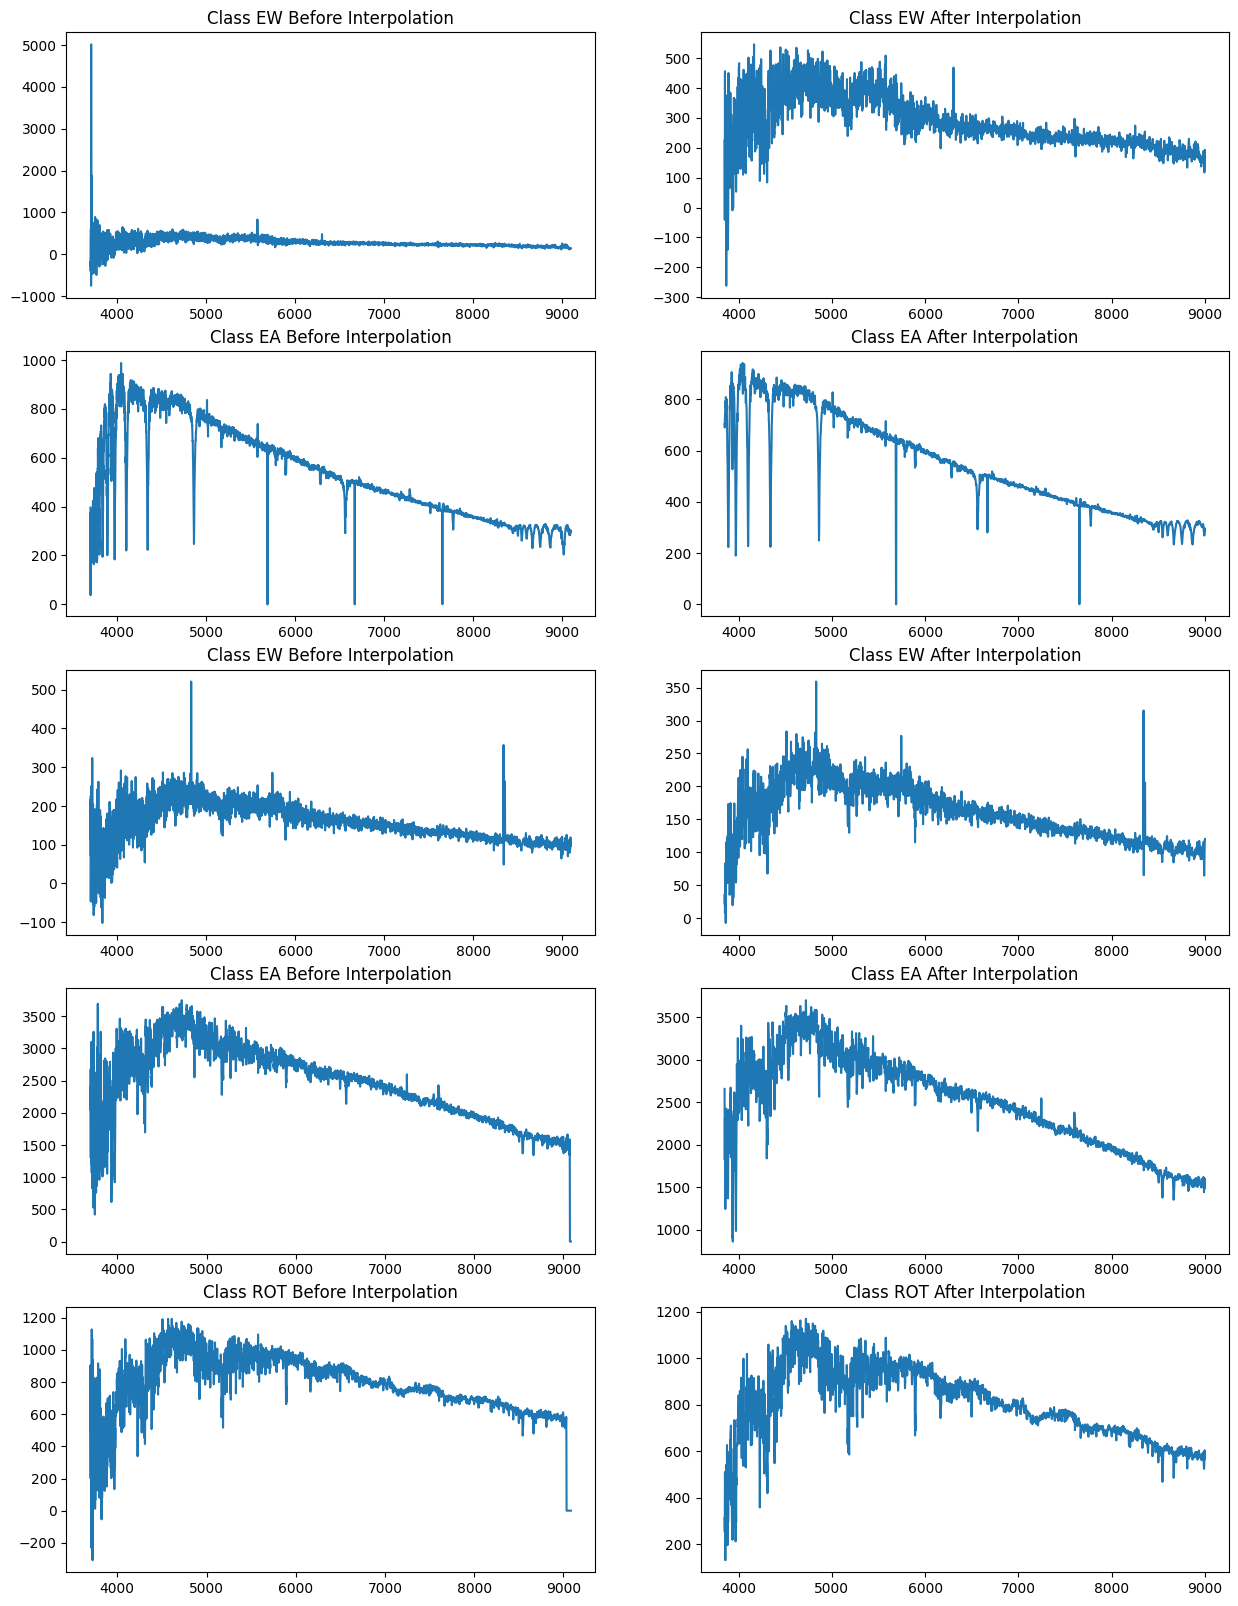

In [94]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for i in range(5):
    spectra = ds_train[i]['spectra'][0][0]
    y = ds_train[i]['classes'][0][0]

    wavelengths, fluxes = spectra[:, 0], spectra[:, 1]
    regular_wavelengths = np.arange(3850, 9002, 2)
    interpolated_fluxes = np.interp(regular_wavelengths, wavelengths, fluxes)

    axs[i, 0].plot(wavelengths, fluxes)
    axs[i, 0].set_title(f'Class {ds_train.target_lookup[y]} Before Interpolation')
    axs[i, 1].plot(regular_wavelengths, interpolated_fluxes)
    axs[i, 1].set_title(f'Class {ds_train.target_lookup[y]} After Interpolation')

plt.show()

In [28]:
ds_train[i]['spectra'][0][0][:, 0].min(), ds_train[i]['spectra'][0][0][:, 0].max()

(3699.6958, 9083.768)

In [30]:
ds_train.df['variable_type'].value_counts()

variable_type
EW       5109
SR       3846
EA       2428
RRAB     2070
EB       1656
ROT      1537
RRC       692
M         272
HADS      238
DSCT      214
DCEP       36
DCEPS      18
RRD        12
CWB        11
CWA        11
Name: count, dtype: int64